# Skin Ridge Model
The following is a simulation model for finger ridges and their impact on tacile receptors

## Imports
Handles all the import statements

In [1]:
from numpy.typing import NDArray
import numpy as np
import matplotlib.pyplot as plt
from noise import pnoise2
from scipy.integrate import solve_ivp

## Ridge Generation
Different surfaces for the simulations will be made.
These will include the following:
- Flat Surface
- Wave-Like Ridges
- Spiral Ridges

In [2]:
# Flat Surface
def generate_flat(shape=(256, 256), height=0.5) -> NDArray[np.float16]:
    return np.ones(shape=shape) * height

In [3]:
# Wave-Like Ridges
def generate_wave(shape=(256, 256), scale=50.0, ridge_freq=15.0) -> NDArray[np.float16]:
    height, width = shape
    noise_array = np.zeros((height, width))

    for y in range(height):
        for x in range(width):
            # Basic Perlin noise
            nx = x / scale
            ny = y / scale
            noise_val = pnoise2(nx, ny, octaves=4, persistence=0.5, lacunarity=2.0)
            
            # Add sine-based ridge modulation (like fingerprint lines)
            sine_mod = np.sin(2 * np.pi * ridge_freq * (x / width + 0.3 * np.sin(y / 30.0)))
            
            # Combine Perlin noise and sine ridge pattern
            noise_array[y, x] = noise_val + 0.5 * sine_mod

    # Normalize to 0–1
    noise_array = (noise_array - noise_array.min()) / (noise_array.max() - noise_array.min())
    return noise_array

In [4]:
# Spiral Ridges
def generate_spiral(shape=(256, 256), ridge_freq=25.0, noise_scale=40.0, noise_strength=0.5) -> NDArray[np.float16]:
    height, width = shape
    cx, cy = width // 2, height // 2

    spiral_pattern = np.zeros((height, width))

    for y in range(height):
        for x in range(width):
            dx = x - cx
            dy = y - cy
            r = np.sqrt(dx**2 + dy**2)
            theta = np.arctan2(dy, dx)

            # Spiral ridge pattern based on radius and angle
            spiral_ridge = np.sin(ridge_freq * r / width + theta)

            # Add Perlin noise distortion
            nx = x / noise_scale
            ny = y / noise_scale
            noise_val = pnoise2(nx, ny, octaves=4, persistence=0.5, lacunarity=2.0)

            # Combine spiral and noise
            value = spiral_ridge + noise_strength * noise_val
            spiral_pattern[y, x] = value

    # Normalize to 0–1
    spiral_pattern = (spiral_pattern - spiral_pattern.min()) / (spiral_pattern.max() - spiral_pattern.min())
    return spiral_pattern

## Kevin-Voigt Model
The deformation can be represented as a kevin-voigt model

In [5]:
# Kelvin-Voigt model for skin deformation
def kelvin_voigt_model(t, y, stiffness, damping, pressure):
    # y[0] is displacement (deformation), y[1] is velocity
    displacement, velocity = y
    ddisplacement_dt = velocity
    dvelocity_dt = (pressure(t) - stiffness * displacement - damping * velocity) / stiffness
    return [ddisplacement_dt, dvelocity_dt]

Solve the deformation as an IVP

In [6]:
# Solve using IVP
def solve_skin_deformation(stiffness, damping, pressure, t_span, initial_conditions):
    sol = solve_ivp(kelvin_voigt_model, t_span, initial_conditions, args=(stiffness, damping, pressure), dense_output=True)
    return sol

## Receptor Detection
Calculate the resulting response from each detector type

In [16]:
def sa1_response(pattern, signal):
    return [np.mean((1 - x)*pattern) for x in signal]

def sa2_response(pattern, signal):
    return [np.std((1 - x)*pattern) for x in signal]

def fa1_response(pattern, signal):
    return [np.max(np.abs(np.diff((1 - x)*pattern))) for x in signal]

def fa2_response(pattern, signal):
    return [np.max(np.abs(np.diff((1 - x)*pattern))) for x in signal]

## Simulations
Generates all the skin meshs and run them in the simulations

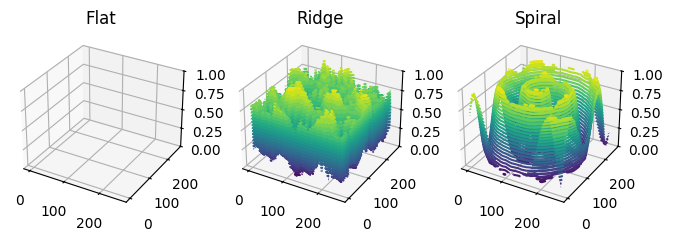

In [8]:
# Generate the skin mesh
flat_mesh = generate_flat()
ridge_mesh = generate_wave()
spiral_mesh = generate_spiral()

# Visualize
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

# set up the figure and Axes
x = np.arange(0, 256)
y = np.arange(0, 256)
max_res = 25

ax1.contour3D(x, y, flat_mesh, max_res)
ax1.set_zlim(0, 1)
ax1.set_title('Flat')

ax2.contour3D(x, y, ridge_mesh, max_res)
ax2.set_zlim(0, 1)
ax2.set_title('Ridge')

ax3.contour3D(x, y, spiral_mesh, max_res)
ax3.set_zlim(0, 1)
ax3.set_title('Spiral')

plt.show()

In [9]:
# Generate Pressure Signal
pressure_signal = lambda time : np.exp(-((time - 2.5) ** 2) / 0.5)  # Gaussian pressure peak

In [10]:
# Parameters for Kelvin-Voigt model (subject to change)
stiffness = 1.0
damping = 0.1
t_span = (0, 5)
initial_conditions = [0, 0]  # Starting at rest (displacement=0, velocity=0)

In [17]:
# Solve for skin deformation using IVP for each fingerprint model
solution_strain = solve_skin_deformation(stiffness, damping, pressure_signal, t_span, initial_conditions)
deformation_mesh = solution_strain.y[0]

# Extract the time steps from the solver
solver_time = solution_strain.t

In [18]:
# Compute receptor responses for all models
sa1_out_ridge = sa1_response(ridge_mesh, deformation_mesh)
sa2_out_ridge = sa2_response(ridge_mesh, deformation_mesh)
fa1_out_ridge = fa1_response(ridge_mesh, deformation_mesh)
fa2_out_ridge = fa2_response(ridge_mesh, deformation_mesh)

sa1_out_spiral = sa1_response(spiral_mesh, deformation_mesh)
sa2_out_spiral = sa2_response(spiral_mesh, deformation_mesh)
fa1_out_spiral = fa1_response(spiral_mesh, deformation_mesh)
fa2_out_spiral = fa2_response(spiral_mesh, deformation_mesh)

sa1_out_flat = sa1_response(flat_mesh, deformation_mesh)
sa2_out_flat = sa2_response(flat_mesh, deformation_mesh)
fa1_out_flat = fa1_response(flat_mesh, deformation_mesh)
fa2_out_flat = fa2_response(flat_mesh, deformation_mesh)

## Visualization
Visualize the results from the simulation

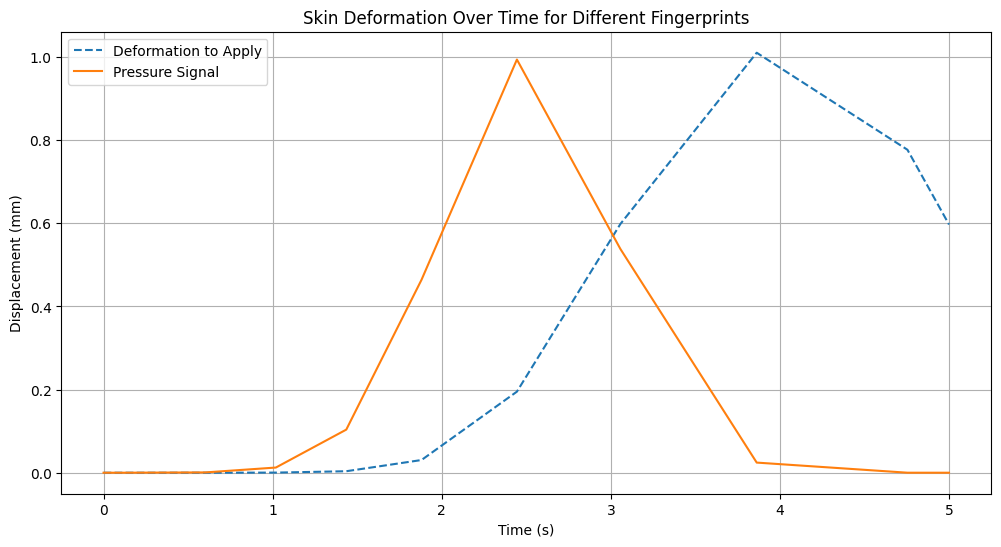

In [19]:
# Plot the deformation over time for all three models
plt.figure(figsize=(12, 6))
plt.plot(solver_time, deformation_mesh, '--', label="Deformation to Apply")
plt.plot(solver_time, pressure_signal(solver_time), label="Pressure Signal")
plt.title("Skin Deformation Over Time for Different Fingerprints")
plt.xlabel("Time (s)")
plt.ylabel("Displacement (mm)")
plt.grid(True)
plt.legend()
plt.show()

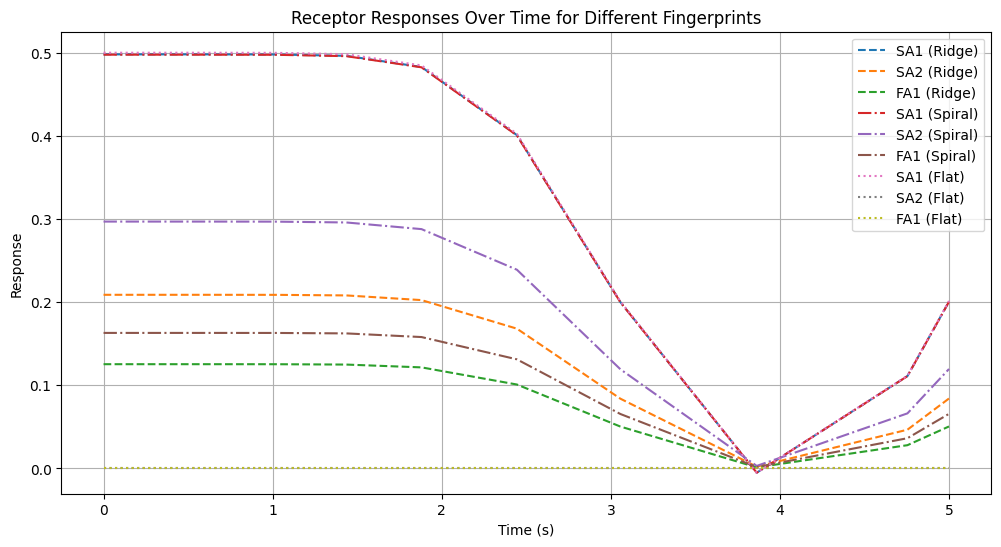

In [20]:
# Plot receptor responses for all three models
plt.figure(figsize=(12, 6))
plt.plot(solver_time, sa1_out_ridge, label="SA1 (Ridge)", linestyle="--")
plt.plot(solver_time, sa2_out_ridge, label="SA2 (Ridge)", linestyle="--")
plt.plot(solver_time, fa1_out_ridge, label="FA1 (Ridge)", linestyle="--")
# plt.plot(solver_time, fa2_out_ridge, label="FA2 (Ridge)", linestyle="--")

plt.plot(solver_time, sa1_out_spiral, label="SA1 (Spiral)", linestyle="-.")
plt.plot(solver_time, sa2_out_spiral, label="SA2 (Spiral)", linestyle="-.")
plt.plot(solver_time, fa1_out_spiral, label="FA1 (Spiral)", linestyle="-.")
# plt.plot(solver_time, fa2_out_spiral, label="FA2 (Spiral)", linestyle="-.")

plt.plot(solver_time, sa1_out_flat, label="SA1 (Flat)", linestyle=":")
plt.plot(solver_time, sa2_out_flat, label="SA2 (Flat)", linestyle=":")
plt.plot(solver_time, fa1_out_flat, label="FA1 (Flat)", linestyle=":")
# plt.plot(solver_time, fa2_out_flat, label="FA2 (Flat)", linestyle=":")

plt.title("Receptor Responses Over Time for Different Fingerprints")
plt.xlabel("Time (s)")
plt.ylabel("Response")
plt.legend()
plt.grid(True)
plt.show()

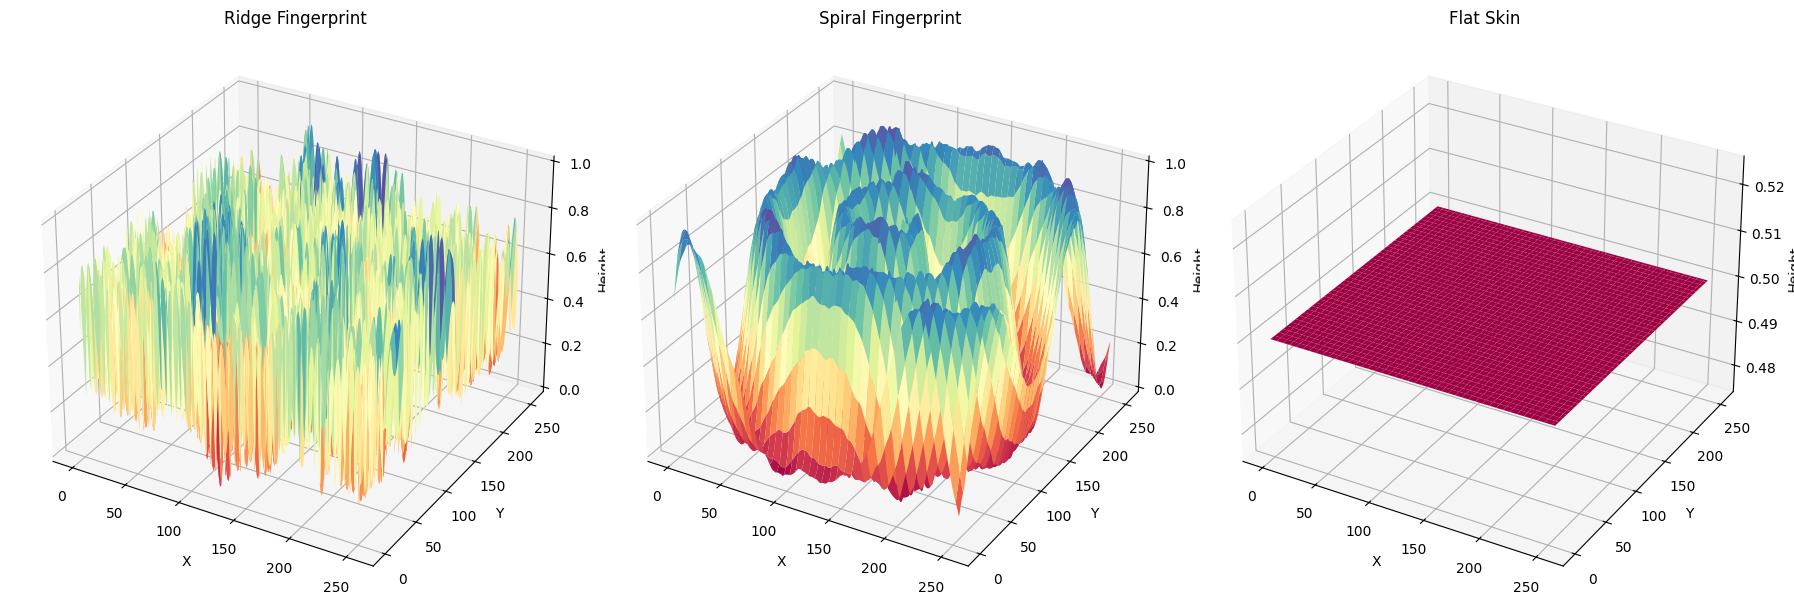

In [15]:
# 3D plots for fingerprint and pressure map
x = np.arange(0, 256)
y = np.arange(0, 256)
X, Y = np.meshgrid(x, y)

# Plot the fingerprint ridge pattern in 3D
fig = plt.figure(figsize=(18, 6))

# Fingerprint Pattern - Ridge
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(X, Y, ridge_mesh, cmap='Spectral', edgecolor='none')
ax1.set_title("Ridge Fingerprint")
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.set_zlabel("Height")

# Fingerprint Pattern - Spiral
ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(X, Y, spiral_mesh, cmap='Spectral', edgecolor='none')
ax2.set_title("Spiral Fingerprint")
ax2.set_xlabel("X")
ax2.set_ylabel("Y")
ax2.set_zlabel("Height")

# Flat Fingerprint
ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(X, Y, flat_mesh, cmap='Spectral', edgecolor='none')
ax3.set_title("Flat Skin")
ax3.set_xlabel("X")
ax3.set_ylabel("Y")
ax3.set_zlabel("Height")

plt.tight_layout()
plt.show()